## 信用卡欺诈检测

基于信用卡交易记录数据建立分类模型来预测哪些交易记录是异常的哪些是正常的。

### 任务流程：
* 加载数据，观察问题
* 针对问题给出解决方案
* 数据集切分
* 评估方法对比
* 逻辑回归模型
* 建模结果分析
* 方案效果对比

### 1 数据读取与分析

- 读取数据

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [22]:
data = pd.read_csv("creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


- 查看样本分布

284807


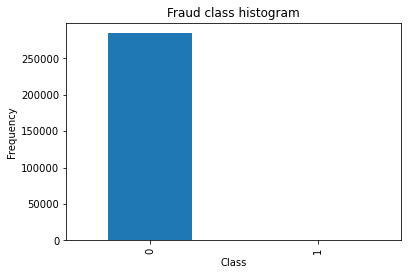

In [55]:
count_classes = pd.value_counts(data['Class'],sort = True).sort_index()  #sort_index()按索引排序 
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
print(count_classes.sum())

>- 样本类别不均衡，需要进行解决
- 样本类别不均衡解决方案：
    1. 欠采样
    2. 过采样

`注意` ：在开始阶段应该多提出各种解决和对比方案，尽可能先把全局规划制定完整

### 2 数据预处理

>- 特征标准化：
    - 模型不像人类，它可能会认为数值大的数据更重要，所以这里需要将Amount列数据进行标准化
    - 特征标准化就是希望数据在处理完之后每个特征数值都在较小范围内浮动
    - 公式：$Z=\dfrac{X-X{mean}}{std(X)}$

>- sklearn：
    - 提供几乎所有机器学习算法，一两行代码即可完成建模工作
    - 提供机器学习中最核心三大模块（分类、回归、聚类）的实现方法供调用，还包括数据降维、模型选数据预处理等模块
    - 多看其API

- 利用sklearn进行特征标准化

In [24]:
from sklearn.preprocessing import StandardScaler
#将Amount列的值标准化进行标准化，并用标准化之后值新创建一列normAmount
#reshape(-1,1)是指将数据转换成一列的形式
data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))
data.drop(['Time','Amount'],axis=1,inplace=True) #设置inplace=True才真正drop
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


- 欠采样

In [25]:
np.random.seed(1)
#特征
X = data.loc[:,data.columns!='Class']
#标签
y = data.loc[:,data.columns=='Class']
number_records_fraud = len(data[data.Class==1])
#得到所有异常样本索引
fraud_indices = np.array(data[data.Class==1].index)
#得到所有正常样本的索引
normal_indices =np.array(data[data.Class==0].index)
#在正常样本中随机采样出与异常样本相同个数的样本，并取其索引；replace=True表示可以反复取同一个数，False则反之
random_normal_indices = np.random.choice(normal_indices,number_records_fraud,replace=False) 
#把异常样本和采样得到的正常样本索引拿到手
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])
#根据索引得到欠采样所有样本点
under_sample_data = data.iloc[under_sample_indices,:]
X_undersample = under_sample_data.loc[:,under_sample_data.columns!='Class']
y_undersample = under_sample_data.loc[:,under_sample_data.columns=='Class']
#打印采样后的正负样本比例
print("正常样本所占整体比例：",len(under_sample_data[under_sample_data.Class==0])/len(under_sample_data))
print("异常样本所占整体比例：",len(under_sample_data[under_sample_data.Class==1])/len(under_sample_data))
print("欠采样策略总体样本数量：",len(under_sample_data))

正常样本所占整体比例： 0.5
异常样本所占整体比例： 0.5
欠采样策略总体样本数量： 984


>- 数据集的划分
    - 训练集：用于建立模型
    - 测试集：在所有建模工作完成之后，用于对这个模型效果进行测试
    - 验证集：用于建立模型过程中，帮助模型进行调参和模型选择；从训练集中划分出来

- 划分数据集，先进行训练集与测试集的划分，运用sklearn（切分验证集的工作留到建模部分）

In [26]:
from sklearn.model_selection import train_test_split
#对整个数据集进行切分，random_state为随机种子
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print("原始训练集包含样本数量：", len(X_train))
print("原始测试集包含样本数量：", len(X_test))
print("原始样本总数：", len(X))

#对欠采样数据集进行切分
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample, y_undersample, test_size=0.3, random_state=0)
print("欠采样训练集包含样本数量：", len(X_train_undersample))
print("欠采样测试集包含样本数量：", len(X_test_undersample))
print("欠采样样本总数：", len(X_undersample))

原始训练集包含样本数量： 199364
原始测试集包含样本数量： 85443
原始样本总数： 284807
欠采样训练集包含样本数量： 688
欠采样测试集包含样本数量： 296
欠采样样本总数： 984


- 考虑模型评估方法

> - 模型评估
    - 选择合适的评估方法非常重要，它为整个实验提供决策的服务
    - 准确率：预测正确的样本数占总数的比例$Accuracy=\dfrac{TP+TN}{TP+TN+FP+FN}$
    - 召回率：所有正例中有多少被判为正例$Recall=\dfrac{TP}{TP+FN}$
    - 精确度：判断为正例的样本中有多少是真的正例$Recall=\dfrac{TP}{TP+FP}$

- 考虑过拟合（引入正则化惩罚）

> - 正则化惩罚
    - 过拟合：随着模型复杂程度增加，训练集效果越来越好，测试集效果越来越差
    - 模型复杂度由参数决定
    - 如果在训练集上得到的参数值忽高忽低，很可能导致过拟合，***正则化惩罚就是惩罚较大的权重参数，让它们对结果影响小一点***，从而缓解过拟合
    - 惩罚项会和目标函数组合在一起，让模型在迭代过程中就开始重视这个问题
  > - L1正则化：$J=J_{0}+\alpha\displaystyle \sum_{w}\left\vert w\right\vert$
  > - L2正则化：$J=J_{0}+\alpha\displaystyle \sum_{w} w^2$
  - L2正则化对参数求平方，让大的更大，相对惩罚也就越多
  - 正则化项可以理解为“惩罚项”
  - $\alpha$表示正则惩罚的力度
      - $\alpha$值很大，说明要非常严格地对待权重参数，惩罚的结果影响很大
      - $\alpha$值很小，惩罚的结果影响不大

`注意：`最终结果的定论由测试集决定，训练集上的效果仅供参考，因为训练集上过拟合现象十分常见

### 3 建立模型

> 关于建模
- 在sklearn包中，所有算法的建模调用都是类似的
    1. 首先选择需要的算法模型并传入超参数
    2. 然后.fit()传入实际数据进行迭代
    3. 最后用.predict()进行预测

- 逻辑回归模型中，仅需要对$\alpha$进行调参实验，下面针对不同验证集分别进行建模与评估分析

`注意：`在sklearn包中，C参数的意义是倒过来的，C=0.01表示正则力度较大

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import recall_score

In [28]:
def printing_Kfold_scores(x_train_data, y_train_data):
    #定义k_fold工具
    fold = KFold(5, shuffle=False) #shufffle=True指每次都打乱数据集之后再划分
    #定义不同的正则化惩罚力度（候选参数）
    c_param_range = [0.01, 0.1, 1, 10, 100]
    #展示结果用的表格;range(len(c_param_range),2)=null
    result_table = pd.DataFrame(index=range(len(c_param_range), 2), columns = ['C_parameter', 'Mean recall score'])
    result_table['C_parameter'] = c_param_range
    
    j = 0 #第几个候选参数
    for c_param in c_param_range:
        print('-------------------------------------')
        print('正则化惩罚力度：',c_param)
        print('-------------------------------------')
        print('') #换行
        recall_accs = []
        
        #enmuerate用于将一个可遍历的数据对象组合成一个索引序列，start=1指索引从1开始
        #indices表示k折划分后产生的k个训练集验证集组合，iteration为组合的索引从1开始
        #indices[0]=训练集样本索引,indices[1]=验证集样本索引
        for iteration, indices in enumerate(fold.split(y_train_data),start=1):
            #指定算法模型，并给定参数
            lr = LogisticRegression(C = c_param, penalty='l1',solver = 'liblinear')
            #训练模型，这里用训练集，索引为0
            lr.fit(x_train_data.iloc[indices[0],:].values,y_train_data.iloc[indices[0],:].values.ravel()) #ravel将数组拉为一维的
            #建立好模型后，预测模型结果，这里用验证集，索引为1;fit与predict传入的都是验证集样本的value而不是dataframe
            y_pred_undersample = lr.predict(x_train_data.iloc[indices[1],:].values)
            #有了预测结果之后就可以进行评估了，recall_score需要传入预测值和真实值
            recall_acc = recall_score(y_train_data.iloc[indices[1],:].values,y_pred_undersample)
            #一会还要算平均，所以把每一步的结果都先保存起来
            recall_accs.append(recall_acc)
            print('Interation', iteration, '：召回率 = ', recall_acc)
        #执行完所有交叉验证后，计算平均结果
        result_table.loc[j,'Mean recall score'] = np.mean(recall_accs)
        j += 1
        print('')
        print('平均召回率', np.mean(recall_accs))
        print('')
        
    #找到最好的参数
    best_c = result_table.loc[result_table['Mean recall score'].astype('float32').idxmax()]['C_parameter']
    
    #打印最好的结果
    print('*********************************************************************************')
    print('效果最好的模型所选的参数 = ', best_c)
    print('*********************************************************************************')
    
    return best_c
        

> 解决问题1
- 问题描述：shuffle must be True or False; got 5
- 原来：
    - `fold = KFold(len(y_train_data), 5, shuffle=False)`
    - `for iteration, indices in enumerate(fold,start=1):`
- 改进：
    - `fold = KFold(5, shuffle=False)`
    - `for iteration, indices in enumerate(fold.split(y_train_data,start=1):`
    
> 解决问题2
- 问题描述：Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.
- 查阅API发现，solver的可选参数有如下要求：
     - 'newton-cg', 'lbfgs', 'sag' and 'saga' handle L2 or no penalty
     - 'liblinear' and 'saga' also handle L1 penalty
- 原来：
     - `lr = LogisticRegression(C = c_param, penalty='l1')`
- 改进：
     - `lr = LogisticRegression(C = c_param, penalty='l1', solver = 'liblinear')`
     
> 解决问题3
- 问题描述：DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
- 原来：
    - `lr.fit(x_train_data.iloc[indices[0],:],y_train_data.iloc[indices[0],:].values)`
- 改进：
    - `lr.fit(x_train_data.iloc[indices[0],:],y_train_data.iloc[indices[0],:].values.ravel())`
    
>解决问题4
- 问题描述：UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
- 原来：`lr.fit(x_train_data.iloc[indices[0],:],y_train_data.iloc[indices[0],:].values.ravel())`
- 改进：`lr.fit(x_train_data.iloc[indices[0],:].values,y_train_data.iloc[indices[0],:].values.ravel())`

In [31]:
# 传入欠采样策略训练集
best_c = printing_Kfold_scores(X_train_undersample,y_train_undersample)

-------------------------------------
正则化惩罚力度： 0.01
-------------------------------------

Interation 1 ：召回率 =  0.9315068493150684
Interation 2 ：召回率 =  0.9178082191780822
Interation 3 ：召回率 =  1.0
Interation 4 ：召回率 =  0.9594594594594594
Interation 5 ：召回率 =  0.9545454545454546

平均召回率 0.9526639964996129

-------------------------------------
正则化惩罚力度： 0.1
-------------------------------------

Interation 1 ：召回率 =  0.8493150684931506
Interation 2 ：召回率 =  0.863013698630137
Interation 3 ：召回率 =  0.9322033898305084
Interation 4 ：召回率 =  0.9324324324324325
Interation 5 ：召回率 =  0.8939393939393939

平均召回率 0.8941807966651245

-------------------------------------
正则化惩罚力度： 1
-------------------------------------

Interation 1 ：召回率 =  0.8493150684931506
Interation 2 ：召回率 =  0.8904109589041096
Interation 3 ：召回率 =  0.9830508474576272
Interation 4 ：召回率 =  0.9459459459459459
Interation 5 ：召回率 =  0.9090909090909091

平均召回率 0.9155627459783485

-------------------------------------
正则化惩罚力度： 10
----------------

- 为了知道模型的具体表现，需要再深入分析：  
借助测试集，并将预测结果直观地进行展示————混淆矩阵

`注意：`下面的代码当成混淆矩阵模版，用的时候传入自己的数据即可

In [10]:
#cm：混淆矩阵，classes：分类类别
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    绘制混淆矩阵
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

召回率： 0.9387755102040817


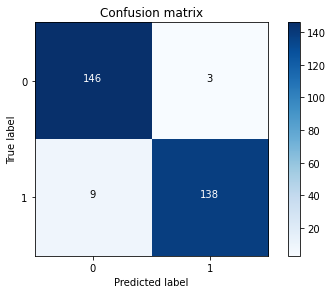

In [18]:
from sklearn.metrics import confusion_matrix
import itertools
#先训练好模型
lr = LogisticRegression(C = best_c, penalty = 'l1',solver='liblinear')
lr.fit(X_train_undersample.values, y_train_undersample.values.ravel())
#传入测试集进行预测
y_pred_undersample = lr.predict(X_test_undersample.values)
#计算混淆矩阵,传入测试集预测值与真实值
cnf_matrix = confusion_matrix(y_test_undersample, y_pred_undersample)
#打印召回率
np.set_printoptions(precision = 2) #设置小数位数
print("召回率：",cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
#绘制混淆矩阵
class_names = [0,1] #分类类别
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')

`注意：`上述测试结果虚高，因为测试集是欠采样的测试集，这份测试集是处理之后异常样本和正常样本比例均衡的理想状态
> - 测试环节 
    - 在测试时需要用原始数据的测试集进行测试
    - 在实际的测试中，不仅要考虑评估方法、模型的具体指标（召回率、精度等），还要注重实际应用情况，再深入混淆矩阵中，看看还有哪些实际问题

- 下面用原始数据的测试集进行测试

召回率： 0.9183673469387755


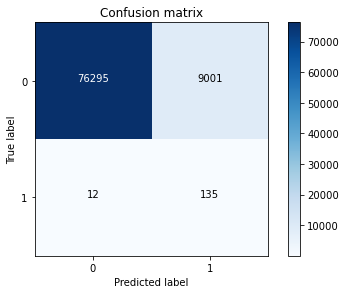

In [19]:
#先训练好模型
lr = LogisticRegression(C = best_c, penalty = 'l1',solver='liblinear')
lr.fit(X_train_undersample.values, y_train_undersample.values.ravel())
#传入测试集进行预测
y_pred = lr.predict(X_test.values)
#计算混淆矩阵,传入测试集预测值与真实值
cnf_matrix = confusion_matrix(y_test, y_pred)
#打印召回率
np.set_printoptions(precision = 2) #设置小数位数
print("召回率：",cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
#绘制混淆矩阵
class_names = [0,1] #分类类别
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')

- 从上述混淆矩阵中可以看到有9022个样本被“误杀”，模型出现大问题，需要改进

> - 模型改进
    - 方法一：对模型调整参数，不断优化算法
    - 方法二（推荐）：在数据层面做一些处理

- 下面先考虑逻辑回归中分类阈值对结果的影响
    - sklearn中可以用.predict()来得到分类结果（默认阈值为0.5），也可以用.predict_proba()来得到其概率值
    - 阈值设置得越大，说明只有非常异常的样本才能当作异常
    - 阈值设置得很小，就是宁可错杀也不肯放过

给定阈值为: 0.1 时测试集召回率为 1.0
给定阈值为: 0.2 时测试集召回率为 1.0
给定阈值为: 0.3 时测试集召回率为 1.0
给定阈值为: 0.4 时测试集召回率为 0.9727891156462585
给定阈值为: 0.5 时测试集召回率为 0.9387755102040817
给定阈值为: 0.6 时测试集召回率为 0.8775510204081632
给定阈值为: 0.7 时测试集召回率为 0.8163265306122449
给定阈值为: 0.8 时测试集召回率为 0.7551020408163265
给定阈值为: 0.9 时测试集召回率为 0.5782312925170068


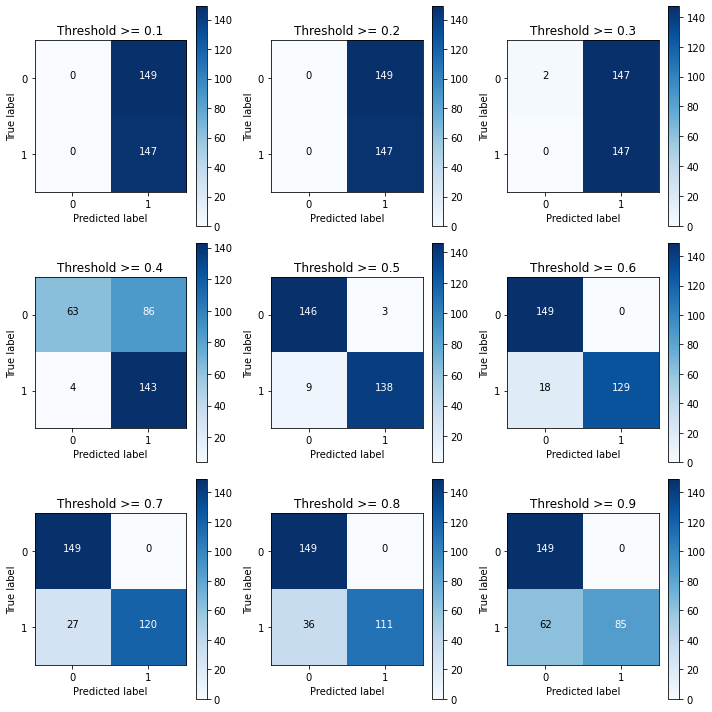

In [15]:
#用之前最好的参数进行建模
lr = LogisticRegression(C=0.01,penalty='l1',solver='liblinear')
#训练模型，还是用的欠采样训练集与测试集
lr.fit(X_train_undersample.values, y_train_undersample.values.ravel())
#得到预测结果的概率值(此时默认阈值为0.5)
#.predict_proba()返回n行k列的数组，第i行第j列表示第i个样本预测为第j个标签的概率
y_pred_undersample_proba = lr.predict_proba(X_test_undersample.values) 
#指定不同的阈值
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
plt.figure(figsize=(10,10))
j = 1
# #用混淆矩阵进行展示
for i in thresholds:
    #比较预测概率与给定阈值
    y_test_preditions_high_recall = y_pred_undersample_proba[:,1] > i #判断数组中每个元素（元素也是一个数组）的第二列是否大于i，返回bool
    
    plt.subplot(3,3,j)
    j += 1
    cnf_matrix = confusion_matrix(y_test_undersample, y_test_preditions_high_recall)
    np.set_printoptions(precision = 2)
    
    print("给定阈值为:", i, "时测试集召回率为", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Threshold >= %s'%i)

- 具体选择哪个阈值，需要从实际业务的角度出发

- 下面采用过采样方案，试试能否优化模型

> - 过采样策略SMOTE（插值法）
    1. 第一步：对于少数类中每一个样本，以欧式距离为标准，计算它到少数类样本集中所有样本的距离，经过排序得到其近邻样本
    2. 第二步：根据样本不平衡比例设置一个采样倍率N，对于每一个少数样本，从其近邻开始依次选择N个样本
    3. 对于每一个选出的近邻样本，分别与原样本按照如下的公式构建新的样本数据：$x_{new}=x+rand(0,1)\times(\overset{\thicksim}{x}-x)$
- 总结：对于每一个异常样本，首先找到距离其最近的同类样本，然后在它们之间，插入一个样本作为新的异常样本
- 使用imblearn工具包即可完成SMOTE过采样,只需传入特征数据和标签

In [50]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd

In [44]:
credit_cards = pd.read_csv('creditcard.csv')
columns = credit_cards.columns
features_columns = columns.delete(len(columns)-1) #特征中去掉标签列

features = credit_cards[features_columns]
labels = credit_cards['Class']
#划分训练集与测试集
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=0)

In [49]:
over_sampler = SMOTE(random_state=0)
os_features,os_labels = over_sampler.fit_resample(features_train,labels_train)

In [66]:
#训练集正反例样本数
print(len(os_labels[os_labels["Class"]==1]))
print(len(os_labels[os_labels["Class"]==0]))

199019
199019


In [67]:
os_features = pd.DataFrame(os_features)
os_labels = pd.DataFrame(os_labels)
best_c = printing_Kfold_scores(os_features,os_labels)

-------------------------------------
正则化惩罚力度： 0.01
-------------------------------------

Interation 1 ：召回率 =  0.9142857142857143
Interation 2 ：召回率 =  0.88
Interation 3 ：召回率 =  0.9716742539200809
Interation 4 ：召回率 =  0.9622771866795633
Interation 5 ：召回率 =  0.9617747183036668

平均召回率 0.938002374637805

-------------------------------------
正则化惩罚力度： 0.1
-------------------------------------

Interation 1 ：召回率 =  0.9142857142857143
Interation 2 ：召回率 =  0.88
Interation 3 ：召回率 =  0.972862923621649
Interation 4 ：召回率 =  0.9641614430891756
Interation 5 ：召回率 =  0.9606692878766943

平均召回率 0.9383958737746466

-------------------------------------
正则化惩罚力度： 1
-------------------------------------

Interation 1 ：召回率 =  0.9142857142857143
Interation 2 ：召回率 =  0.88
Interation 3 ：召回率 =  0.9730905412240769
Interation 4 ：召回率 =  0.9643373070207394
Interation 5 ：召回率 =  0.9644629241147136

平均召回率 0.9392352973290489

-------------------------------------
正则化惩罚力度： 10
-------------------------------------

Inter

- 绘制混淆矩阵

召回率： 0.8843537414965986


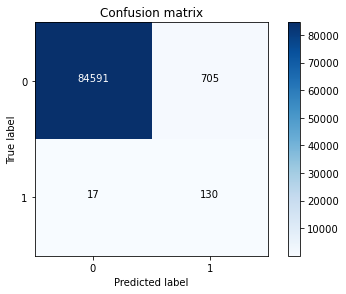

In [69]:
lr = LogisticRegression(C=best_c, penalty='l1', solver='liblinear')
lr.fit(os_features.values, os_labels.values.ravel())
y_pred = lr.predict(features_test.values)

cnf_matrix = confusion_matrix(labels_test, y_pred)
np.set_printoptions(precision=2)

print("召回率：",cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

#绘制
class_names = [0,1]
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')


- 召回率相较欠采样有所下降，但是误杀比例大大下降
- 再根据实际任务需求选择方案

`注意：`对于不同的任务与数据源，没有一成不变的答案，任何结果都需要通过实验证明，所以当大家遇到问题时，最好的解决方案就是通过大量的实验分析

### 项目总结

（1）我们做任务工作之前都一定要先进行数据检查，看看数据有什么问题，针对这些问题来选择解决方案。在此项目中，我们首选对数据进行了观察，发现了其中样本不均衡的问题。

（2）这里我们提出了两种方法，下采样和过采样，两条路线来进行对比实验，任何实际问题来了之后，我们都不会一条路走到黑的，没有对比就没有伤害，通常都会得到一个基础模型，然后对各种方法进行对比，找到最合适的，所以在任务开始之前，一定得多动脑筋多一手准备，得到的结果才有可选择的余地。

（3）在建模之前，需要对数据进行各种预处理的操作，比如数据标准化，缺失值填充等，这些都是必要操作，由于数据本身已经给定了特征，此处我们还没有提到特征工程这个概念，后续实战中我们会逐步引入，其实数据预处理的工作是整个任务中最为最重也是最苦的一个阶段，数据处理的好不好对结果的影响是最大的。

（4）先选好评估方法，再进行建模。建模的目的就是为了得到结果，但是我们不可能一次就得到最好的结果，肯定要尝试很多次，所以一定得有一个合适的评估方法，可以用这些通用的，比如Recall，准确率等，也可以根据实际问题自己指定评估指标。

（5）选择合适的算法，这里我们使用的是逻辑回归，也详细分析了其中的细节，这是因为我们刚刚讲解完逻辑回归的原理就拿它来练手了，之后我们还会讲解其他算法，并不一定非要用逻辑回归来完成这个任务，其他算法可能效果会更好。但是有一点我希望大家能够理解就是在机器学习中并不是越复杂的算法越实用，恰恰相反，越简单的算法反而应用的越广泛。逻辑回归就是其中一个典型的代表了，简单实用，所以任何分类问题都可以把逻辑回归当做一个待比较的基础模型。

（6）模型的调参也是很重要的，之前我们通过实验也发现了不同的参数可能会对结果产生较大的影响，这一步也是必须的，后续实战内容我们还会来强调调参的细节，这里就简单概述一下了。对于参数我建立大家在使用工具包的时候先看看其API文档，知道每一个参数的意义，再来实验选择合适的参数值。

（7）得到的结果一定要和实际任务结合在一起，有时候虽然得到的结果指标还不错，但是实际应用却成了问题，所以测试环节也是必不可少的。